# Comparing a USGSCSM and ISIS camera for Dawn FC

In [1]:
import os 
import tempfile
import pvl
os.environ["ISISROOT"] = "/usgs/pkgs/isis3"

import pysis
from pysis import isis

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.dawn_drivers import DawnFcPds3NaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Make a CSM sensor model

In [2]:
imageLink = 'https://pdsimage.wr.usgs.gov/Missions/Dawn/Ceres/DWNCSFC2_1A/DATA/IMG/20150604_SURVEY/20150617_CYCLE5/FC21A0038582_15170161546F6F.IMG'
!wget -N -P data/ {imageLink}
fileName = 'data/' + os.path.split(imageLink)[1]

camera = knoten.csm.create_csm(fileName)

--2019-08-02 16:03:52--  https://pdsimage.wr.usgs.gov/Missions/Dawn/Ceres/DWNCSFC2_1A/DATA/IMG/20150604_SURVEY/20150617_CYCLE5/FC21A0038582_15170161546F6F.IMG
Resolving pdsimage.wr.usgs.gov (pdsimage.wr.usgs.gov)... 8.27.177.76
Connecting to pdsimage.wr.usgs.gov (pdsimage.wr.usgs.gov)|8.27.177.76|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/FC21A0038582_15170161546F6F.IMG’ not modified on server. Omitting download.



## Ingest the image, run spiceinit, and create an isd

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.dawnfc2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)

# Create temp metakernel using the same kernels from the spincinit'd cube,
# update the config to point to temp directory, and create driver
# using the temp metakernel
img_label = pvl.load(cub_loc)
year = img_label['IsisCube']['Instrument']['StartTime'].year

with tempfile.NamedTemporaryFile("r+") as metakernel:
    metakernel_path = os.path.split(metakernel.name)[0]
    metakernel.name = metakernel_path + '/dawn_{}.tm'.format(year)
    util.write_metakernel_from_cube(cub_loc, metakernel.name)

    ale.config['dawn'] = metakernel_path
    with DawnFcPds3NaifSpiceDriver(fileName) as driver:
        usgscsmString = to_usgscsm(driver)
        usgscsm_dict = json.loads(usgscsmString)

        csm_isd = os.path.splitext(fileName)[0] + '.json'
        json.dump(usgscsm_dict, open(csm_isd, 'w'))

## Compute and display differences between USGSCSM and ISIS

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

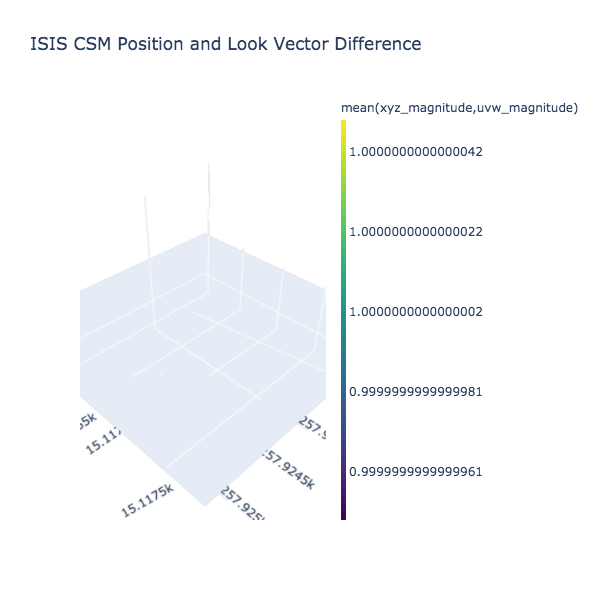

In [18]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

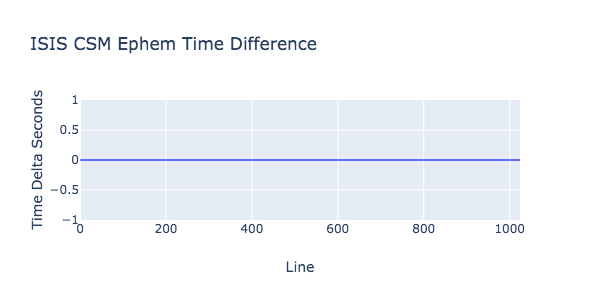

In [6]:
Image(csmisis_diff_ephem_plot_bytes)

In [7]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.016207,0.868019,-20.047451,0.004011,0.002543,0.000577
std,0.000000,0.000000,0.000000,0.023167,0.014654,0.001273
min,1.016207,0.868019,-20.047451,-0.032290,-0.020426,-0.000804
25%,1.016207,0.868019,-20.047451,-0.016142,-0.010209,-0.000583
50%,1.016207,0.868019,-20.047451,0.004028,0.002546,0.000213
75%,1.016207,0.868019,-20.047451,0.024177,0.015301,0.001557
max,1.016207,0.868019,-20.047451,0.040255,0.025509,0.003049


In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

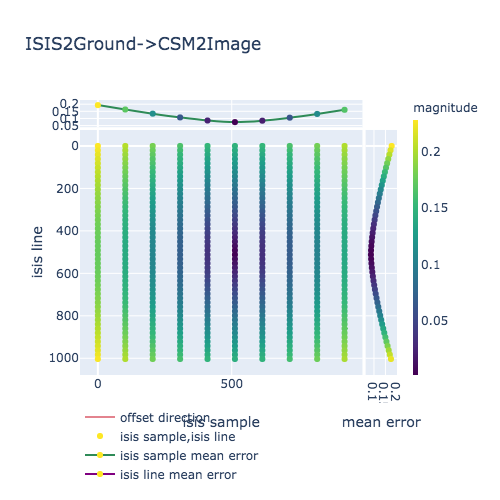

In [9]:
Image(isis2csm_plot.to_image())

In [10]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.001768,0.018534
std,0.085957,0.099466
min,-0.147945,-0.137230
25%,-0.076070,-0.068007
50%,-0.001764,0.018542
75%,0.072543,0.105105
max,0.144343,0.174453


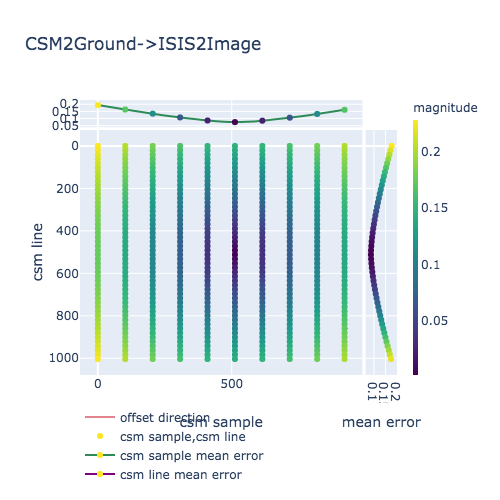

In [11]:
Image(csm2isis_plot.to_image())

In [12]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.001762,-0.018559
std,0.085852,0.099562
min,-0.143865,-0.174390
25%,-0.072528,-0.105141
50%,0.001764,-0.018561
75%,0.076052,0.068004
max,0.147379,0.137312


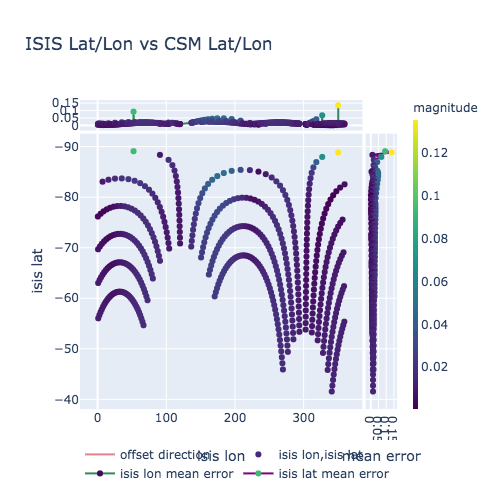

In [13]:
Image(isiscsm_plotlatlon.to_image())

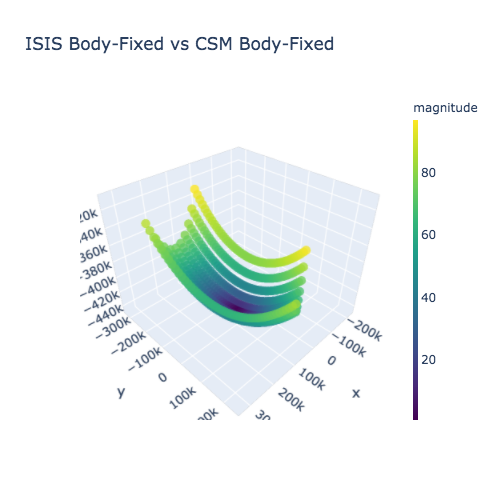

In [14]:
Image(isiscsm_plotbf.to_image())

In [15]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,0.386280,-3.306759,0.701411
std,2.080683,37.775131,14.043587
min,-3.140875,-89.716982,-39.664756
25%,-0.686470,-30.780176,-7.272939
50%,0.156054,-3.486656,0.436994
75%,2.601609,24.280770,9.930546
max,3.139983,84.421198,27.261844
